In [8]:
import numpy as np
import tensorflow as tf
import keras
from keras import Sequential, Model
from keras import layers

In [9]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

In [10]:
from keras.datasets import mnist

# use Keras to import pre-shuffled MNIST database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
# normalize the data to accelerate learning
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [7]:
from keras.utils import np_utils

num_classes = 10 
# print first ten (integer-valued) training labels
print('Integer-valued labels:')
print(y_train[:10])

# one-hot encode the labels
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(y_train[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [6]:
# input image dimensions 28x28 pixel images. 
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('image input shape: ', input_shape)
print('x_train shape:', X_train.shape)

image input shape:  (28, 28, 1)
x_train shape: (60000, 28, 28, 1)


In [7]:
def bottleneck_residual_block(X, f, filters, stage, block, reduce=False, s=2):
    """    
    Arguments:
    X -- input tensor of shape (m, height, width, channels)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    reduce -- boolean, True = identifies the reduction layer at the beginning of each learning stage
    s -- integer, strides
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        # to do that, we need both CONV layers to have similar strides 
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
def ResNet50(input_shape, classes):
    x_input = Input(input_shape)
    
    # Stage 1
    x = Conv2D(64, (7,7), (2,2), kernel_initializer=glorot_uniform(seed=0))(x_input)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((3,3), (2,2))(x)
    
    # Stage 2
    x = bottleneck_residual_block(x, 3, [64, 64, 256],stage=2, block='a', reduce=True, s=1)
    x = bottleneck_residual_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = bottleneck_residual_block(x, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    x = bottleneck_residual_block(x, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = bottleneck_residual_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = bottleneck_residual_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    x = bottleneck_residual_block(x, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = bottleneck_residual_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = AveragePooling2D((1,1))(x)
    
    # Output layer
    x = Flatten()(x)
    x = Dense(classes, activation="softmax", name='fc' + str(classes))(x)
    
    model = Model(inputs = x_input, outputs = x, name="ResNet50")
    
    return model

In [9]:
model = ResNet50(input_shape = (28,28, 1), classes = 10)

In [10]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 11, 11, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 11, 11, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 11, 11, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

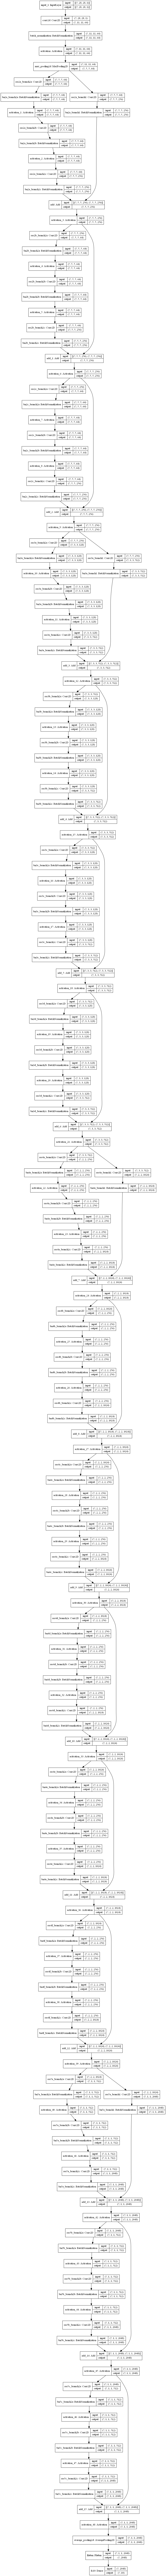

In [11]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

## Callbacks

In [12]:
import os
import datetime
import numpy as np
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 2                                                         
batch_size = 256                                                     

callback = {"early_stopping": EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=False),
            "tensorboard"   : tf.keras.callbacks.TensorBoard(log_dir=log_dir), # %load_ext tensorboard, %tensorboard --logdir logs
            "reduce_lr"     : ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1), patience=5, min_lr=0.5e-6),
            "check_point"   : ModelCheckpoint("model", save_best_only=True, verbose=1),
            "log_csv"       : CSVLogger("training.csv") 
           }

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])                                           
 
history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test),
          epochs=epochs, callbacks=[callback["early_stopping"]])   

Epoch 1/2
235/235 [==============================] - 1379s 6s/step - loss: 0.3444 - accuracy: 0.9086 - val_loss: 0.6242 - val_accuracy: 0.8211
Epoch 2/2
235/235 [==============================] - 1394s 6s/step - loss: 0.0634 - accuracy: 0.9803 - val_loss: 0.0760 - val_accuracy: 0.9758


In [13]:
import matplotlib.pyplot as plt
def plot_metrics(metric_name, title):
    plt.title(title)
    #plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend()
    plt.show()

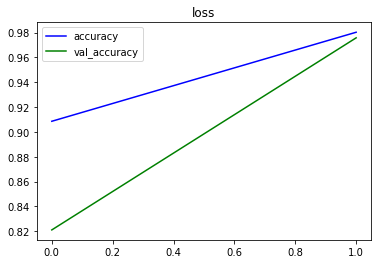

In [14]:
plot_metrics("accuracy", "loss")